# I. Introduction

This data set was collected by Gerhard van de Bunt, and is discussed extensively in van de Bunt (1999) and van de Bunt, van Duijn, and Snijders (1999). The data were collected among a group of university freshmen at 7 time points. The first four time points are three weeks apart, whereas the last three time points are six weeks apart. The original group consisted of 49 students, but due to 'university drop-outs' and after deleting those who did not fill in the questionnaire four or more times, a group was obtained of 32 students for whom almost complete data are available.

At each time step, the students were asked to rate their relationships with all the other students on a six point scale, with response categories described as follows:

1 = *Best friendship*: People whom you would call your 'real' friends

2 = *Friendship* : People with whom you have a good relationship, but whom you do not (yet) consider a 'real' friend

3 = *Friendly relationship* : People with whom you regularly have pleasant contact during classes. The contact could grow into a friendship. 

4 = *Neutral relationship*: People with whom you have not much in common. In case of an accidental meeting the contact is good. The chance of it growing into a friendship is not large

0 = *Unknown person* : People whom you do not know

5 = *Troubled relationship* : People with whom you can't get on very well, and with whom you definitely do not want to start a relationship. There is a certain risk of getting into a conflict

# II. Importing, cleaning and preparing the data

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.algorithms import community
import random
import matplotlib.pyplot as plt
import community
import itertools as it

All the data is in a csv file, representing a matrix $M \in \mathcal{M}_{224x32}(\mathbb{R})$. We import it into the notebook as follows: 

In [4]:
df = pd.read_excel('/Users/cdalyac/Desktop/Datavdb.xlsx',index_col=[0])
df

,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
1,0,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,4,0,0,3,0,3,0,0,0,4,...,0,4,0,4,2,0,2,3,0,4
221,4,4,4,3,4,1,4,4,0,4,...,4,3,4,4,1,1,0,1,4,4
222,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,0,9,9
223,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,0,9


In [5]:
matrix = df.as_matrix()
np.count_nonzero(matrix)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


3821

We see that the matrix is more than half-full (density is $\approx0.5$), keeping in mind that since almost no one knows each other at the first encounter, there are a lot of zeros at the beginning. 

### Data cleaning

Some edges are coded as 6 = item non-response, 9 = actor non-response. We therefore give 0 to non-responses because it's unexploitable.

In [6]:
for i in range (len(matrix)):
    for j in range (len(matrix[i])):
        if matrix[i][j] == 6 or matrix[i][j] == 9 :
            matrix[i][j] = 0

### Seperating the timesteps

In [13]:
def matrix_to_submatrices(matrix,N,M,i,j): #ixj = dimension of the submatrices. We want to cut the matrix for each time step.
    subA = []
    k1 = N // i 
    k2 = M // j
    B = np.array_split(matrix,k1,axis=0)
    for i in range(len(B)):
        subA_i = np.array_split(B[i],k2, axis=1)
        for j in range(len(subA_i)):
            subA.append(np.asarray(subA_i[j]))
    return subA
N = len(matrix) #lignes
M = len(matrix[0]) #colonnes
i = j = 32

In [12]:
time_step_matrices = matrix_to_submatrices(matrix,N,M,i,j)
print(len(time_step_matrices), np.shape(time_step_matrices[1]))

7 (32, 32)


The cutting seperates our data into 7 matrices of size 32x32, corresponding to the 7 time steps when every student notes the others (32 total students).

# III. Fiddling with data: first impressions

We start by looking at one specific time step. Because the time_step = 0 has little information, let's take a look at time_step = 1. Below, we convert the adjacency list to a graph where each edge has an attribute 'weight'

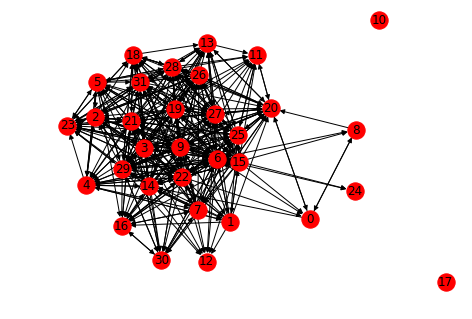

In [14]:
G = nx.from_numpy_matrix(time_step_matrices[1],create_using=nx.DiGraph())
nx.draw(G,with_labels= True, pos=graphviz_layout(G))

Although we can say that student 10 and 17 forgot to fill in the document, this vizualisation doesn't help a lot. Indeed, there a lot of edges and we cannot see the different weights. We therefore decided to plot the subgraphs induced by the different labels (= weights on the edges). 

In [15]:
friends_1=[]
for edge in G.edges():
    a,b = edge[0], edge[1]
    if G[a][b]['weight'] == 1:
        friends.append(edge)
friends_1

[]

Okay, no one came with a good friend to university! 

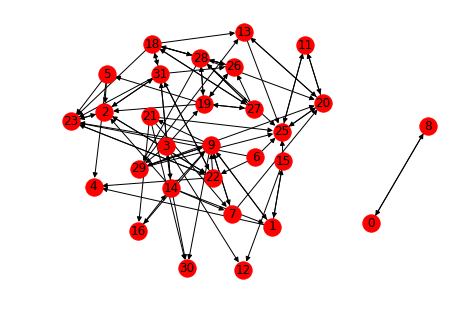

In [17]:
friends_3=[]
for edge in G.edges():
    a,b = edge[0], edge[1]
    if G[a][b]['weight'] == 3:
        friends_3.append(edge)
subG_t1_3 = G.edge_subgraph(friends_3)

nx.draw(subG_t1_3,with_labels= True, pos=graphviz_layout(G))

Now we can start analyzing a bit. The big connected component we see above (for label 3 (= friendly)), seems to indicate that the overall atmosphere in the class is friendly. Note that student 0 and 8 seem to stay together, and don't interact with the rest of the class. A natural question that arises then is the evolution of friendship in the class over time.

# IV. Time dynamics and analysis

## Evolution of labels over time

We take the subgraphs induced for each label, at each timestep, and  save them to Excel files.

In [21]:
def labels_and_times(time_step_matrices):
    labels = [i for i in range(1,6)]
    for i in labels:
        for j in range(len(time_step_matrices)):
            M = time_step_matrices[j].copy()
            for k in range (len(M)):
                for l in range (len(M)):
                    if M[k][l] != i :
                        M[k][l] = 0
            pd.DataFrame(M).to_excel('/Users/cdalyac/Desktop/timesteps_data_EXCEL/Datavdb_label=' + str(i) + '_timestep_'+ str(j) + '.xlsx')


In [22]:
labels_and_times(time_step_matrices)

In [23]:
def time_evolution(label):
    for i in range(7):
        test = pd.read_excel('/Users/cdalyac/Desktop/timesteps_data_EXCEL/Datavdb_label='+str(label)+'_timestep_'+str(i)+'.xlsx',index_col=[0])
        Xmatrix = test.as_matrix()
        X_G = nx.from_numpy_matrix(Xmatrix,create_using=nx.DiGraph())
        plt.figure(i)
        nx.draw(X_G,with_labels= True, pos=graphviz_layout(G))

We can now look at the evolution of one label over time. Let's look for example at the evolution of label 5, *i.e.* conflict. 

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


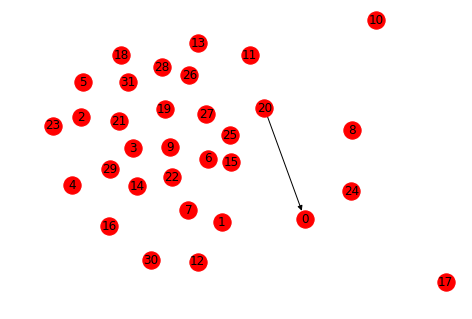

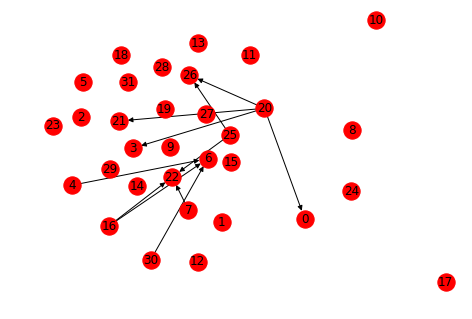

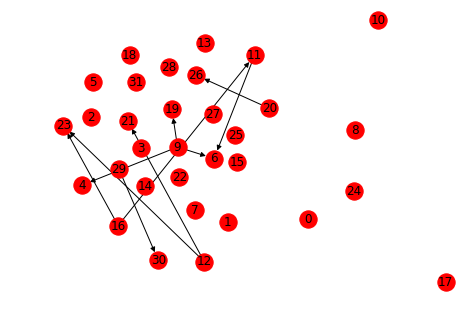

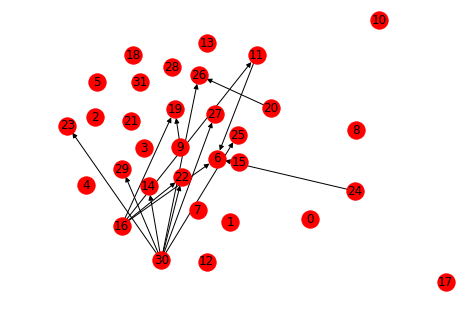

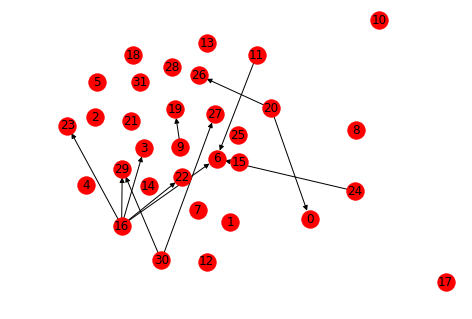

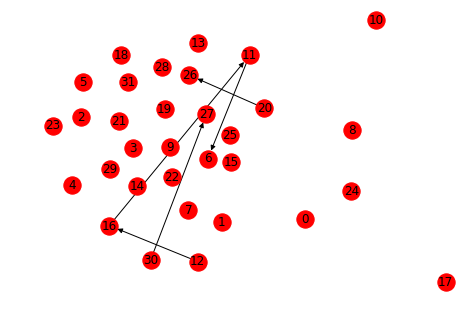

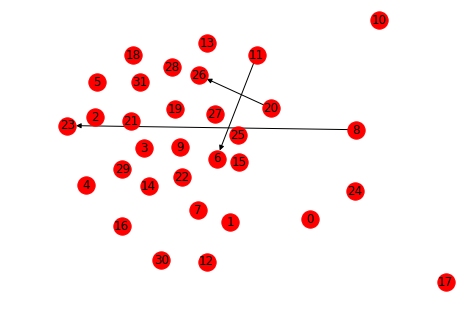

In [30]:
time_evolution(5)

We see that there were two peaks of conflicts in the class (time steps 1 & 3). It's actually funny to look at specific students, such as  student 30: at the time step 4, he seemed to be in conflict with a lot of people. We can also see that student 6 seems to be at the center of many conflicted relationship. Measuring in-degrees in this case might be a helpful way for teachers to isolate conflictuous students...

Let's take a look at the evolution of label 1, corresponding to best friendship. 

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


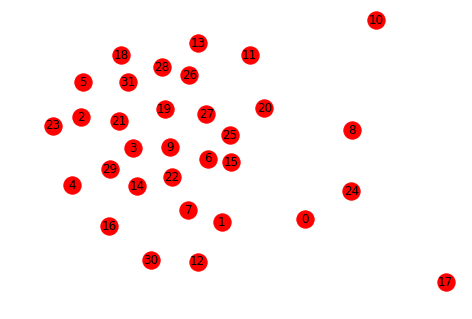

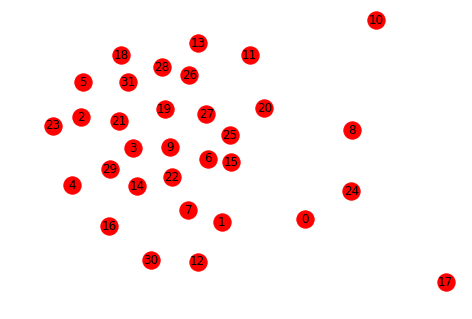

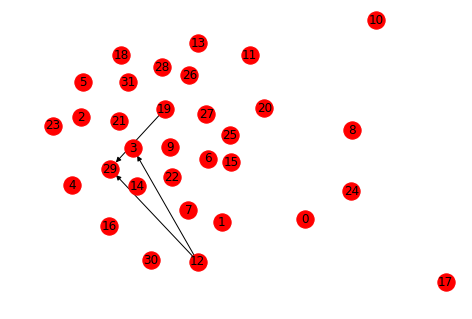

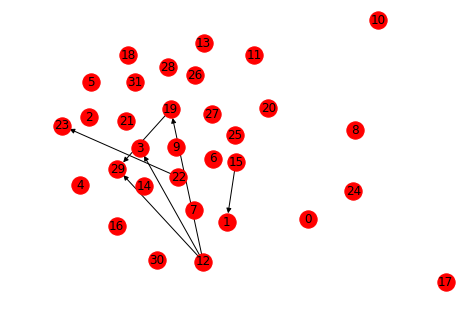

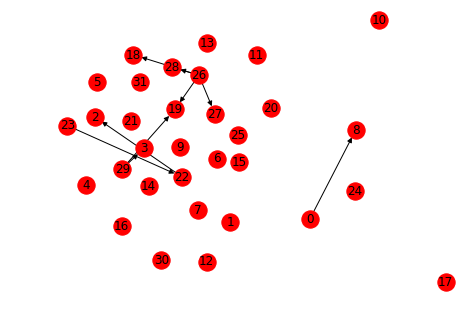

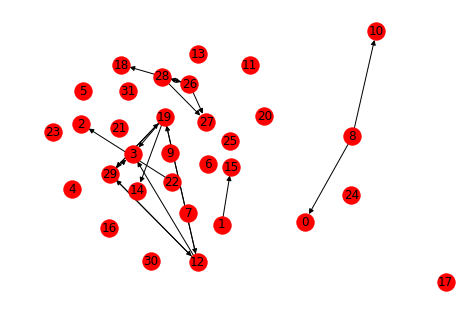

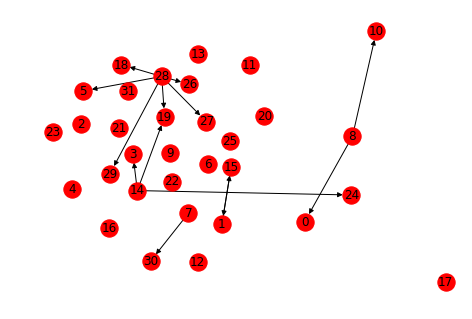

In [35]:
time_evolution(1)

As expected, there are fewer links in the case of best friendship. Interestingly, there seems to be an asymmetry in some of the relationships: looking at the last time step, student 28 seems to consider a lot of people as his best friends, without receiving the reciproqual consideration. This might also indicate the subjectivity of each student regarding his threshold of who qualifies as a best friend. This must be kept in mind when analyzing results! 

To end this part, let's have a look at the evolution of label 2, *i.e.* friendship.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


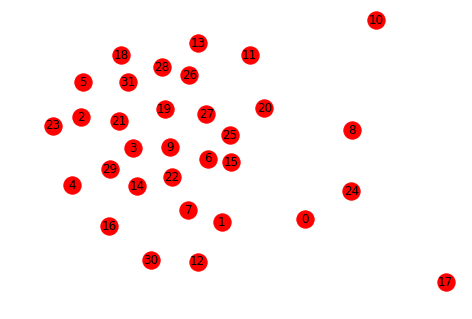

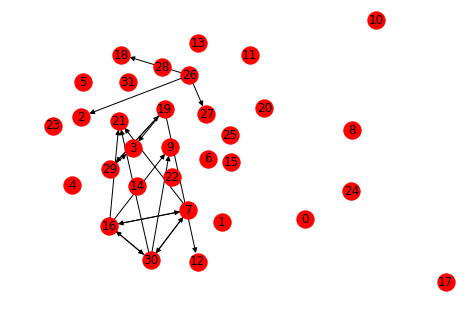

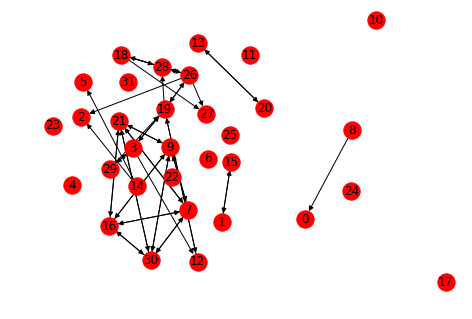

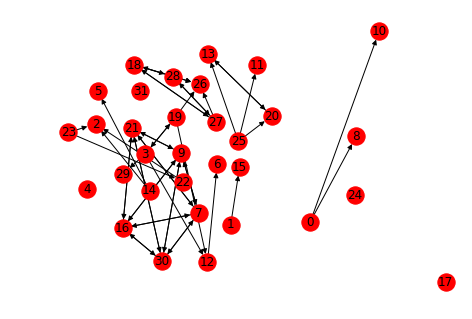

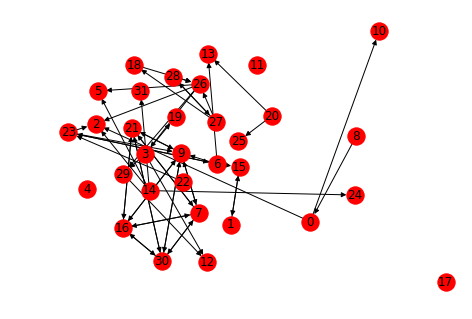

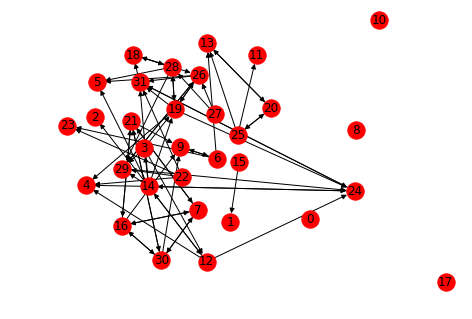

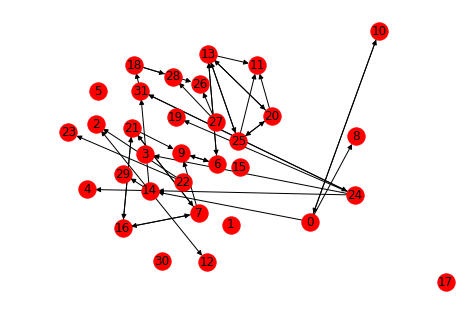

In [36]:
time_evolution(2)

When looking at the evolution of the friendship label, it seems that some communities emerge. Let us use the Louvain algorithm to try and detect communities. 

### Community detection

In [42]:
def community_label(label):  #detects the communities for every time-step
    timestep_partition =[]
    for i in range(7):
        test = pd.read_excel('/Users/cdalyac/Desktop/timesteps_data_EXCEL/Datavdb_label='+str(label)+'_timestep_'+str(i)+'.xlsx',index_col=[0])
        Xmatrix = test.as_matrix()
        X_G = nx.from_numpy_matrix(Xmatrix,create_using=nx.DiGraph())
        partition = community.best_partition(X_G.to_undirected())
        timestep_partition.append(partition)
        #drawing
        size = float(len(set(partition.values())))
        pos = graphviz_layout(X_G)
        count = 0.
        for com in set(partition.values()) :
            count += 1.
            list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
            nx.draw_networkx_nodes(X_G,pos,list_nodes, node_color = str(count / size))
            nx.draw_networkx_edges(X_G, pos, alpha=0.5)
        plt.show()
    return timestep_partition        

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


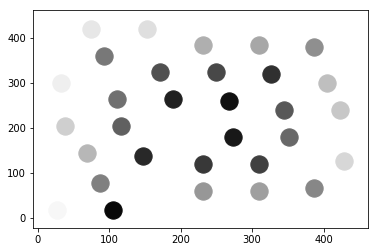

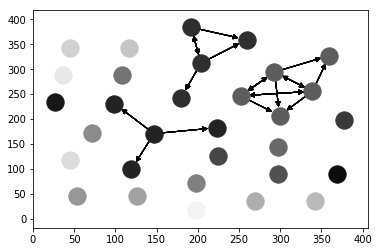

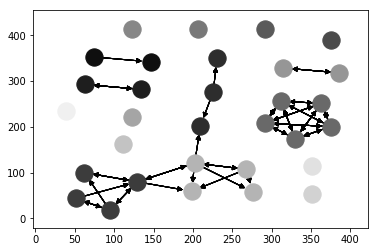

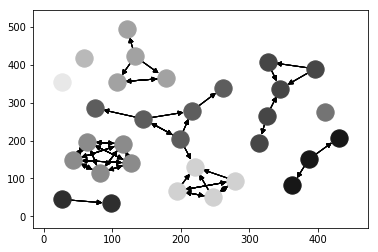

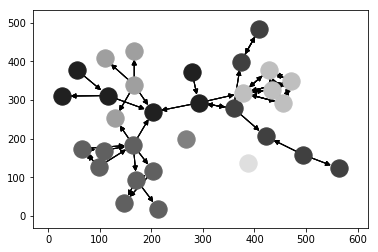

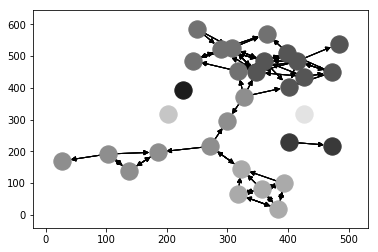

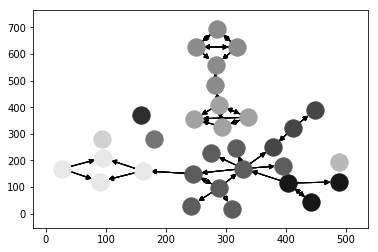

In [43]:
community_2 = community_label(2)

The Louvain algorithm shows us the emergence in time of clusters, and appearences of cliques. This is compatible with social networks, where "the friends of my friends are friends". A question one might have is the evolution of students inside of a clique do they stay, do some enter while others leave? In order to answer to this question, we wrote the following code that show who's in who's clusters.

In [44]:
def connected_components(community): #community est une liste de partitions 
    con_components = []
    for i in range(7):
        d = community[i]
        communities = {','.join(str(k) for k in d.keys() if d[k] == v): v for v in set(d.values())} #keys are the connected components
        con_components.append(communities.keys())
    return con_components

In [45]:
connected_components(community_2)

[dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']),
 dict_keys(['0', '1', '2,18,26,27', '3,12,19,29', '4', '5', '6', '7,9,16,21,30', '8', '10', '11', '13', '14', '15', '17', '20', '22', '23', '24', '25', '28', '31']),
 dict_keys(['0,8', '1,15', '2,5,14', '3,12,19,29', '4', '6', '7,9,16,21,30', '10', '11', '13,20', '17', '18,26,27,28', '22', '23', '24', '25', '31']),
 dict_keys(['0,8,10', '1,15', '2,5,14,22,23', '3,6,12,19,29', '4', '7,9,16,21,30', '11,13,20,25', '17', '18,26,27,28', '24', '31']),
 dict_keys(['0,2,8,10,22,23', '1,6,13,15,20,25', '3,12,18,19,26,27,28,29', '4', '5,14,24,31', '7,9,16,21,30', '11', '17']),
 dict_keys(['0', '1,15', '2,3,4,12,14,19,24,29', '5,18,26,27,28,31', '6,11,13,20,22,23,25', '7,9,16,21,30', '8', '10', '17']),
 dict_keys(['0,8,10', '1', '2,22,23', '3,4,12,14,19,24,29,31', '5', '6,7,9,16,21', '11,13,20,25', '15',

We see that communities aren't very stable. For example, students 0,8 and 10 are part of the same community at time 4, then it seems that they find new friends, but suddenly at the next step they are scattered in other communities, before coming back together for the last timestep. We have seen in class that following the dynamics of communities is a hard problem. Here the problem comes from the fact that the communities calculations made for a certain time step are independent from the results of the previous snapshots. Furthermore, it is possible that good friendships evolve from a weight 2 to a weight 1 (best friendship). This adds a second difficulty as we should try to keep track of the evolution of communities for other labels at the same time (multi-layered graph).

One solution that we investigated was using the DYNAMOGA algorithm mentioned in class, unfortunately time and constraints (translating the code to MATlab) kept us from trying it on our model. We would have tried to modify the fitness function of the genetic algorithm, adding a term in order to give a higher score to communities present for stronger weights (decreasing order of labels as 1= best friend and 5=conflict).

An easier solution was to visualize with Gephi, giving us enough tools to show interesting phenomenons.

### Gephi plots for dynamical evolution (see supplementary material)

For a given timestep, the idea was to plot in Gephi all the edges, where the bolder the edge corresponds to a strong friendship. In addition to this, we had additional data on the students, including their gender, if they smoke or not, and which course they follow. Colouring the nodes according to the different features, we obtained the graphs given in the supplementary material (cf. email). Pink and blue nodes are respectively female and male students, while green and blue nodes represent smokers and non-smoking repectively.

At time 1 we notice that some groups are formed, and the influence of gender looks determining in these cases. It seems more important than the smoking criteria, as few real friendships exist between girls and boys whereas groups of friends include smokers and non-smoking. It seems therefore that gender is an important criteria when meeting new people. 


At intermediate time scales, gender still looks like the discriminating criteria, and smokers are quite diluted in all friend groups. However at long-time scales, girls start to become friends with boys (see for example female student 29), while the smoking classification seems more cliving: student 29 is indeed a smoker and most of her newly-made friends are smokers.




# Conclusion

As you might have guessed, we had a lot of fun trying to analyze the graph structure of the data. Because of its small size, this data set could easily be visualized while having a lot of information to unveil. The dynamical parts were the most interesting, seeing evolutions of communities and we might wonder: are we able to predict theses changes by building some network-based warning indicators? Although this data is a "cas d'école" (haha), it would be a very powerful tool in prediction, as many systems can be modeled by dynamic communities propagating in networks (political parties, viruses, quantum information, etc.).